In [2]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import re
import pickle
from matplotlib import pyplot as plt
import sklearn
from sklearn import datasets, neighbors, linear_model, model_selection, svm
from sklearn.model_selection import train_test_split,KFold,learning_curve, LeavePOut,GridSearchCV

%matplotlib inline

In [3]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.utils as utils

## Feature Extraction

### Load Existing Data

In [4]:
def load_data(pickle_file):
    data = pd.read_pickle(pickle_file)
    # Split the data into training set and test set.
    # DONT look at what is in the test set
    test_data = data.loc[utils.TEST_KEYS]
    train_data = data.loc[data.index.difference(utils.TEST_KEYS)]
    return train_data, test_data

In [5]:
train_inception_concat, test_inception_concat = load_data('data_inception_cnn.pkl')
train_inception_diff, test_inception_diff = load_data('data_inception_cnn_diff.pkl')
train_reduced_dim, test_reduced_dim = load_data("data_inception_cnn_diff_reduced_dim.pkl")
train_reduced_dim_aug, test_reduced_dim_aug = load_data("data_inception_cnn_diff_reduced_dim_augmented.pkl")

#### Baseline

This baseline builds a feature set by pulling pairs of images and creating a difference of the image histograms they produce. The assumption is that files are contained in some input directory in the form patientX-1.jpg, patientX-2.jpg

In [6]:
X_concat = train_inception_concat.drop('y', axis=1)
y_concat = train_inception_concat["y"]

X_diff = train_inception_diff.drop('y', axis=1)
y_diff = train_inception_diff["y"]

X_reduced = train_reduced_dim.drop('y', axis=1)
y_reduced = train_reduced_dim["y"]

X_reduced_aug = train_reduced_dim_aug.drop('y', axis=1)
y_reduced_aug = train_reduced_dim_aug["y"]

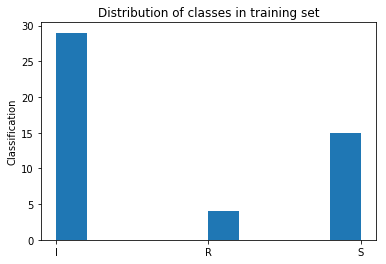

In [7]:
# Plot distribution of datapoints
# Suvadip suggested trying a binary classifier by combining regressed and persistent into one class.
# Then use ROC curve (used in binary classification) to evaluate model
plt.title('Distribution of classes in training set')
plt.ylabel('Classification')
ind = np.arange(3)
plt.hist(y_diff.tolist())
plt.show()

In [15]:
# This is based on recommendation from Suvadip. Leave one out is used for VERY small samples (size 15-20)
lpo = LeavePOut(3)

### KNN Classifier

In [7]:
def train_knn(X, y, multiclass, cv=LeavePOut(3), test_size=0.3):
    params = [{'n_neighbors': [2,3,4,5,6]}]
    knn = GridSearchCV(neighbors.KNeighborsClassifier(), cv=cv, param_grid = params)
    utils.do_CV(X,y, knn, multi_class=multiclass, test_size=test_size)
    return knn.best_estimator_

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.438 (+/-0.210) for {'n_neighbors': 2}
0.500 (+/-0.291) for {'n_neighbors': 3}
0.438 (+/-0.286) for {'n_neighbors': 4}
0.438 (+/-0.212) for {'n_neighbors': 5}
0.453 (+/-0.308) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



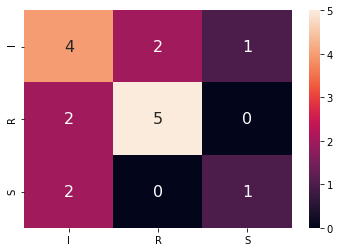

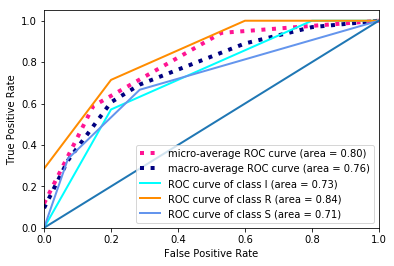


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.50      0.57      0.53         7
          R       0.71      0.71      0.71         7
          S       0.50      0.33      0.40         3

avg / total       0.59      0.59      0.58        17

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.66      0.73      0.69        26
          R       0.75      0.69      0.72        26
          S       0.73      0.67      0.70        12

avg / total       0.71      0.70      0.70        64



In [8]:
# after stratifying
knn_model = train_knn(X_reduced_aug, y_reduced_aug, multiclass=True, cv=7, test_size=0.2)
pickle.dump(knn_model, open("knn_model.pkl", "wb"))

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.474 (+/-0.560) for {'n_neighbors': 2}
0.536 (+/-0.566) for {'n_neighbors': 3}
0.437 (+/-0.564) for {'n_neighbors': 4}
0.460 (+/-0.566) for {'n_neighbors': 5}
0.443 (+/-0.559) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



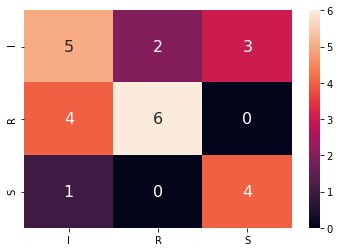

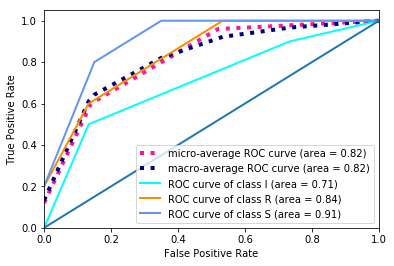


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.50      0.50      0.50        10
          R       0.75      0.60      0.67        10
          S       0.57      0.80      0.67         5

avg / total       0.61      0.60      0.60        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.61      0.74      0.67        23
          R       0.73      0.70      0.71        23
          S       0.86      0.55      0.67        11

avg / total       0.70      0.68      0.68        57



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
train_knn(X_reduced_aug, y_reduced_aug, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.724 (+/-0.500) for {'n_neighbors': 2}
0.639 (+/-0.519) for {'n_neighbors': 3}
0.622 (+/-0.539) for {'n_neighbors': 4}
0.600 (+/-0.544) for {'n_neighbors': 5}
0.534 (+/-0.564) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       1.00      0.67      0.80        12
          R       0.20      1.00      0.33         1
          S       0.00      0.00      0.00         2

avg / total       0.81      0.60      0.66        15


This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.77      1.00      0.87        17
          R       0.67      0.67      0.67         3
          S       1.00      0.64      0.78        14

GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

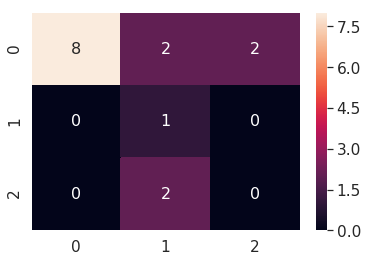

In [20]:
# EXTRA REDUCED
train_knn(X_reduced, y_reduced, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 4}

Grid scores on development set:

0.624 (+/-0.537) for {'n_neighbors': 2}
0.670 (+/-0.525) for {'n_neighbors': 3}
0.672 (+/-0.524) for {'n_neighbors': 4}
0.636 (+/-0.526) for {'n_neighbors': 5}
0.622 (+/-0.555) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



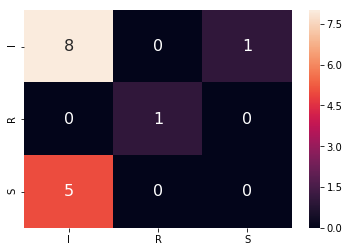

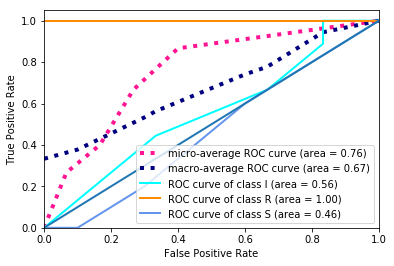


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.62      0.89      0.73         9
          R       1.00      1.00      1.00         1
          S       0.00      0.00      0.00         5

avg / total       0.44      0.60      0.50        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.70      0.95      0.81        20
          R       0.00      0.00      0.00         3
          S       0.86      0.55      0.67        11

avg / total       0.69      0.74      0.69        34



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [23]:
train_knn(X_reduced, y_reduced, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.650 (+/-0.525) for {'n_neighbors': 2}
0.647 (+/-0.527) for {'n_neighbors': 3}
0.637 (+/-0.543) for {'n_neighbors': 4}
0.637 (+/-0.539) for {'n_neighbors': 5}
0.614 (+/-0.558) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



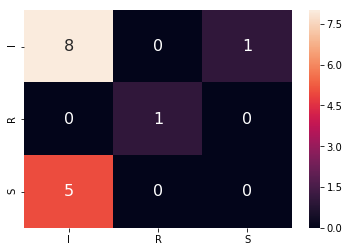

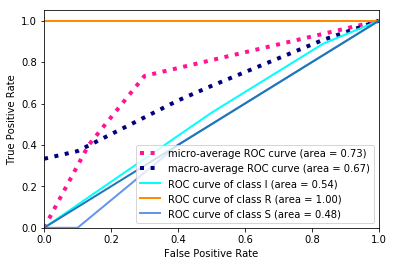


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.62      0.89      0.73         9
          R       1.00      1.00      1.00         1
          S       0.00      0.00      0.00         5

avg / total       0.44      0.60      0.50        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.71      1.00      0.83        20
          R       1.00      0.67      0.80         3
          S       1.00      0.36      0.53        11

avg / total       0.83      0.76      0.73        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
train_knn(X_diff, y_diff, True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.555 (+/-0.540) for {'n_neighbors': 2}
0.383 (+/-0.520) for {'n_neighbors': 3}
0.519 (+/-0.554) for {'n_neighbors': 4}
0.477 (+/-0.549) for {'n_neighbors': 5}
0.477 (+/-0.539) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



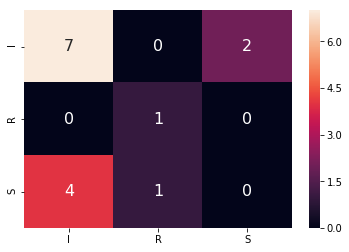

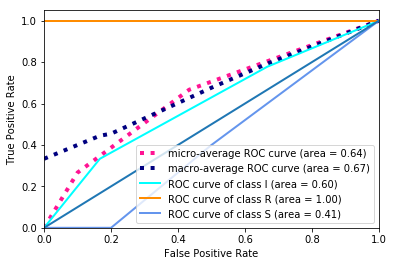


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.64      0.78      0.70         9
          R       0.50      1.00      0.67         1
          S       0.00      0.00      0.00         5

avg / total       0.42      0.53      0.46        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.71      1.00      0.83        20
          R       1.00      0.67      0.80         3
          S       1.00      0.36      0.53        11

avg / total       0.83      0.76      0.73        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
train_knn(X_concat, y_concat, True)

### KNN binary

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.625 (+/-0.167) for {'n_neighbors': 2}
0.714 (+/-0.379) for {'n_neighbors': 3}
0.714 (+/-0.243) for {'n_neighbors': 4}
0.643 (+/-0.259) for {'n_neighbors': 5}
0.661 (+/-0.394) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



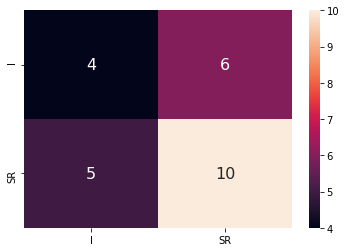

ROC AUC score
0.58


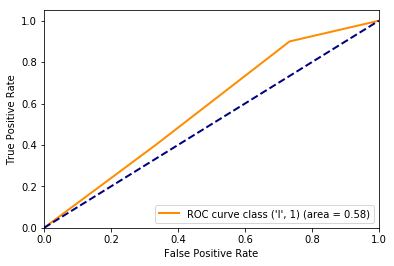


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.44      0.40      0.42        10
         SR       0.62      0.67      0.65        15

avg / total       0.55      0.56      0.56        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.82      0.78      0.80        23
         SR       0.85      0.88      0.87        33

avg / total       0.84      0.84      0.84        56



In [9]:
m = train_knn(X_reduced_aug, y_reduced_aug, multiclass=False, cv=5, test_size=0.3) # BAD MODEL

In [ ]:
train_knn(X_reduced_aug, y_reduced_aug, False)

# Tuning hyper-parameter



# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.752 (+/-0.478) for {'n_neighbors': 2}
0.727 (+/-0.481) for {'n_neighbors': 3}
0.701 (+/-0.519) for {'n_neighbors': 4}
0.682 (+/-0.521) for {'n_neighbors': 5}
0.586 (+/-0.562) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          I       1.00      0.67      0.80        12
          R       0.43      1.00      0.60         3

avg / total       0.89      0.73      0.76        15

ROC AUC score
0.833333333333

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.77      1.00      0.87        17
          R       1.00      0.71      0.83        17

avg / total       0.89      0.85      0.85        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

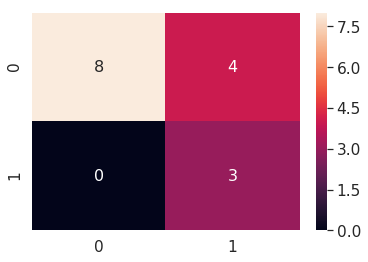

In [26]:
# extra reduced
train_knn(X_reduced, y_reduced, False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.674 (+/-0.528) for {'n_neighbors': 2}
0.686 (+/-0.502) for {'n_neighbors': 3}
0.678 (+/-0.522) for {'n_neighbors': 4}
0.682 (+/-0.526) for {'n_neighbors': 5}
0.656 (+/-0.527) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

ROC AUC score
0.583333333333


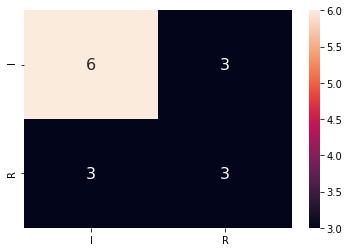

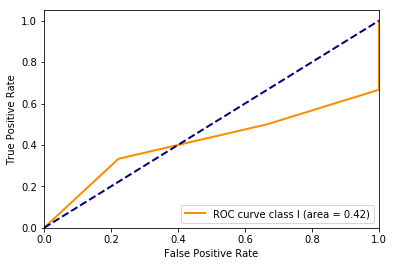


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.67      0.67      0.67         9
          R       0.50      0.50      0.50         6

avg / total       0.60      0.60      0.60        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.86      0.90      0.88        20
          R       0.85      0.79      0.81        14

avg / total       0.85      0.85      0.85        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
train_knn(X_reduced, y_reduced, False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.729 (+/-0.503) for {'n_neighbors': 2}
0.744 (+/-0.487) for {'n_neighbors': 3}
0.669 (+/-0.535) for {'n_neighbors': 4}
0.694 (+/-0.517) for {'n_neighbors': 5}
0.661 (+/-0.546) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

ROC AUC score
0.555555555556


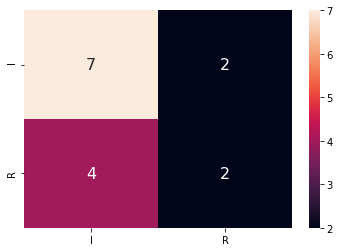

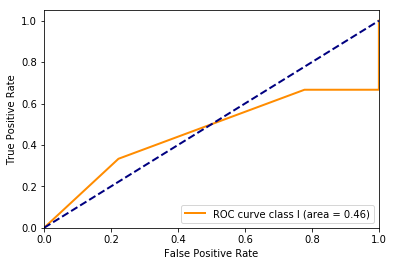


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.64      0.78      0.70         9
          R       0.50      0.33      0.40         6

avg / total       0.58      0.60      0.58        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.90      0.95      0.93        20
          R       0.92      0.86      0.89        14

avg / total       0.91      0.91      0.91        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [29]:
train_knn(X_diff, y_diff, False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'n_neighbors': 2}

Grid scores on development set:

0.597 (+/-0.550) for {'n_neighbors': 2}
0.438 (+/-0.557) for {'n_neighbors': 3}
0.457 (+/-0.543) for {'n_neighbors': 4}
0.388 (+/-0.538) for {'n_neighbors': 5}
0.532 (+/-0.555) for {'n_neighbors': 6}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

ROC AUC score
0.638888888889


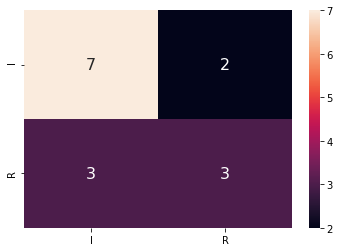

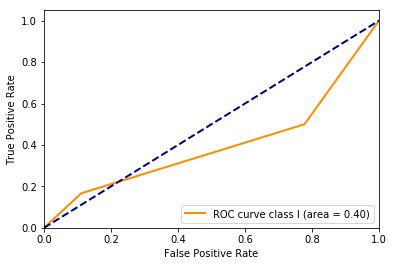


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.70      0.78      0.74         9
          R       0.60      0.50      0.55         6

avg / total       0.66      0.67      0.66        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.80      1.00      0.89        20
          R       1.00      0.64      0.78        14

avg / total       0.88      0.85      0.85        34



GridSearchCV(cv=LeavePOut(p=3), error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [30]:
train_knn(X_concat, y_concat, False)

### Logistic Linear

In [10]:
def train_logistic(X,y, multiclass, cv=LeavePOut(3), test_size=0.3):
    params = [{'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}]
    lr = GridSearchCV(linear_model.LogisticRegression(solver='liblinear'), cv=cv, param_grid = params)
    if multiclass:
        params = [{'C': [0.001,0.01,0.1,1,10,100,1000]}]
        lr = GridSearchCV(linear_model.LogisticRegression(solver='lbfgs', penalty='l2', multi_class="multinomial", max_iter=3000), cv=cv, param_grid = params)
    utils.do_CV(X,y, lr, multi_class=multiclass, test_size=test_size)
    return lr.best_estimator_

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1, 'penalty': 'l2'}

Grid scores on development set:

0.406 (+/-0.052) for {'C': 0.001, 'penalty': 'l1'}
0.766 (+/-0.155) for {'C': 0.001, 'penalty': 'l2'}
0.406 (+/-0.052) for {'C': 0.01, 'penalty': 'l1'}
0.797 (+/-0.221) for {'C': 0.01, 'penalty': 'l2'}
0.406 (+/-0.052) for {'C': 0.1, 'penalty': 'l1'}
0.906 (+/-0.220) for {'C': 0.1, 'penalty': 'l2'}
0.844 (+/-0.238) for {'C': 1, 'penalty': 'l1'}
0.922 (+/-0.226) for {'C': 1, 'penalty': 'l2'}
0.875 (+/-0.218) for {'C': 10, 'penalty': 'l1'}
0.922 (+/-0.226) for {'C': 10, 'penalty': 'l2'}
0.891 (+/-0.166) for {'C': 100, 'penalty': 'l1'}
0.922 (+/-0.226) for {'C': 100, 'penalty': 'l2'}
0.906 (+/-0.180) for {'C': 1000, 'penalty': 'l1'}
0.922 (+/-0.226) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



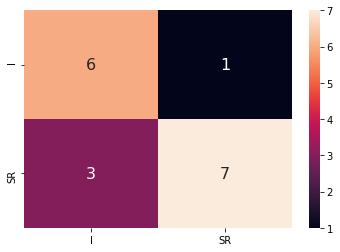

ROC AUC score
0.942857142857


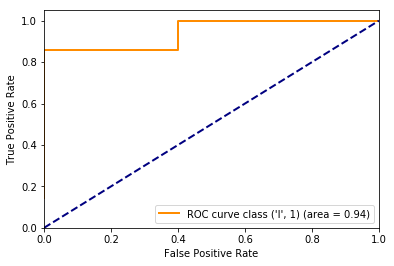


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.67      0.86      0.75         7
         SR       0.88      0.70      0.78        10

avg / total       0.79      0.76      0.77        17

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        26
         SR       1.00      1.00      1.00        38

avg / total       1.00      1.00      1.00        64



In [11]:
# AFTER STRATIFY
lr = train_logistic(X_reduced_aug, y_reduced_aug, False, cv=7, test_size=0.2)
pickle.dump(lr, open("lr_binary_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.1, 'penalty': 'l2'}

Grid scores on development set:

0.411 (+/-0.063) for {'C': 0.001, 'penalty': 'l1'}
0.679 (+/-0.292) for {'C': 0.001, 'penalty': 'l2'}
0.411 (+/-0.063) for {'C': 0.01, 'penalty': 'l1'}
0.732 (+/-0.226) for {'C': 0.01, 'penalty': 'l2'}
0.411 (+/-0.063) for {'C': 0.1, 'penalty': 'l1'}
0.857 (+/-0.173) for {'C': 0.1, 'penalty': 'l2'}
0.786 (+/-0.251) for {'C': 1, 'penalty': 'l1'}
0.857 (+/-0.173) for {'C': 1, 'penalty': 'l2'}
0.786 (+/-0.279) for {'C': 10, 'penalty': 'l1'}
0.857 (+/-0.173) for {'C': 10, 'penalty': 'l2'}
0.804 (+/-0.250) for {'C': 100, 'penalty': 'l1'}
0.857 (+/-0.173) for {'C': 100, 'penalty': 'l2'}
0.821 (+/-0.250) for {'C': 1000, 'penalty': 'l1'}
0.839 (+/-0.230) for {'C': 1000, 'penalty': 'l2'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



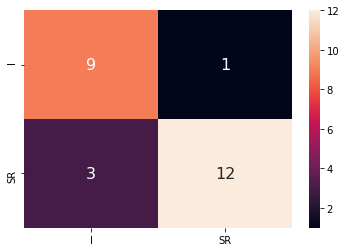

ROC AUC score
0.946666666667


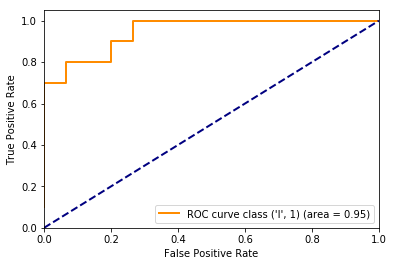


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.75      0.90      0.82        10
         SR       0.92      0.80      0.86        15

avg / total       0.85      0.84      0.84        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
         SR       1.00      1.00      1.00        33

avg / total       1.00      1.00      1.00        56



In [12]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, False, 7)
pickle.dump(lr, open("lr_binary_reduced_model_aug.pkl", "wb") )

In [ ]:
lr = train_logistic(X_reduced, y_reduced, False)
pickle.dump(lr, open("lr_binary_reduced_model.pkl", "wb") )

# Tuning hyper-parameter



In [ ]:
lr = train_logistic(X_diff, y_diff, False)
pickle.dump(lr, open("lr_binary_model.pkl", "wb") )

In [ ]:
lr = train_logistic(X_concat, y_concat, False)
pickle.dump(lr, open("lr_binary_concat_model.pkl", "wb") )

### Logistic multiclass model

In [ ]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, True, test_size=0.2)
pickle.dump(lr, open("lr_binary_reduced_model_aug_strat_leavenout.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.672 (+/-0.233) for {'C': 0.001}
0.703 (+/-0.194) for {'C': 0.01}
0.734 (+/-0.182) for {'C': 0.1}
0.750 (+/-0.184) for {'C': 1}
0.750 (+/-0.184) for {'C': 10}
0.734 (+/-0.143) for {'C': 100}
0.750 (+/-0.161) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



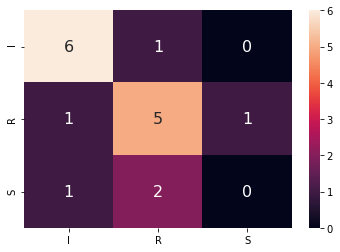

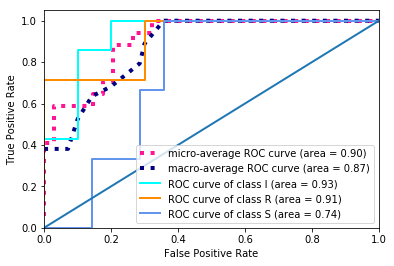


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.75      0.86      0.80         7
          R       0.62      0.71      0.67         7
          S       0.00      0.00      0.00         3

avg / total       0.57      0.65      0.60        17

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        26
          R       1.00      1.00      1.00        26
          S       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        64



In [12]:
lr = train_logistic(X_reduced_aug, y_reduced_aug, True, cv=7, test_size=0.2)
pickle.dump(lr, open("lr_binary_reduced_model_aug_strat.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.732 (+/-0.225) for {'C': 0.001}
0.804 (+/-0.100) for {'C': 0.01}
0.839 (+/-0.171) for {'C': 0.1}
0.804 (+/-0.174) for {'C': 1}
0.821 (+/-0.163) for {'C': 10}
0.821 (+/-0.163) for {'C': 100}
0.839 (+/-0.155) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



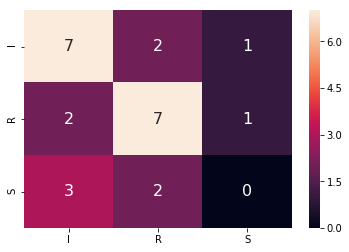

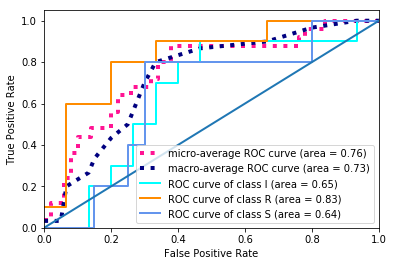


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.58      0.70      0.64        10
          R       0.64      0.70      0.67        10
          S       0.00      0.00      0.00         5

avg / total       0.49      0.56      0.52        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
          R       1.00      1.00      1.00        23
          S       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        56



In [13]:
lr2 = train_logistic(X_reduced_aug, y_reduced_aug, True, 7)
pickle.dump(lr2, open("lr_multi_reduced_model_aug.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1000}

Grid scores on development set:

0.588 (+/-0.551) for {'C': 0.001}
0.578 (+/-0.570) for {'C': 0.01}
0.682 (+/-0.538) for {'C': 0.1}
0.760 (+/-0.500) for {'C': 1}
0.764 (+/-0.496) for {'C': 10}
0.769 (+/-0.491) for {'C': 100}
0.769 (+/-0.494) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



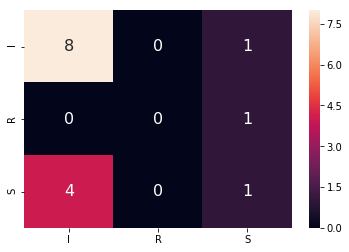

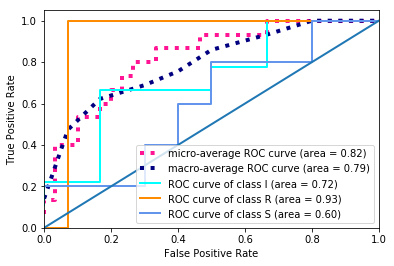


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.67      0.89      0.76         9
          R       0.00      0.00      0.00         1
          S       0.33      0.20      0.25         5

avg / total       0.51      0.60      0.54        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        20
          R       1.00      1.00      1.00         3
          S       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        34



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
lr2 = train_logistic(X_reduced, y_reduced, True)

pickle.dump(lr2, open("lr_multi_model_reduced.pkl", "wb") )

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 1}

Grid scores on development set:

0.588 (+/-0.551) for {'C': 0.001}
0.624 (+/-0.546) for {'C': 0.01}
0.753 (+/-0.513) for {'C': 0.1}
0.772 (+/-0.492) for {'C': 1}
0.771 (+/-0.492) for {'C': 10}
0.771 (+/-0.495) for {'C': 100}
0.765 (+/-0.499) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



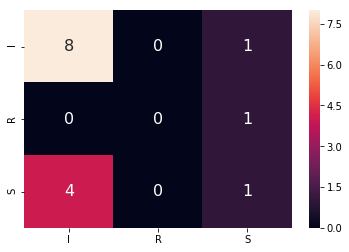

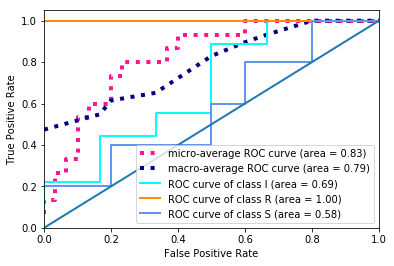


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.67      0.89      0.76         9
          R       0.00      0.00      0.00         1
          S       0.33      0.20      0.25         5

avg / total       0.51      0.60      0.54        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        20
          R       1.00      1.00      1.00         3
          S       1.00      1.00      1.00        11

avg / total       1.00      1.00      1.00        34



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [64]:
lr2 = train_logistic(X_diff, y_diff, True)

pickle.dump(lr2, open("lr_multi_model_diff.pkl", "wb") )

In [1]:
lr2 = train_logistic(X_concat, y_concat, True)

pickle.dump(lr2, open("lr_multi_concat_model_diff.pkl", "wb") )

NameError: name 'train_logistic' is not defined

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

def train_bagging_DT(X,y, multiclass, cv=LeavePOut(3), test_size=0.3):
    #params = [{'n_estimators': [10,20, 50]}]
    model = BaggingClassifier(GradientBoostingClassifier(), n_estimators=7)

    results = model_selection.cross_val_score(model, X, y, cv=model_selection.KFold(n_splits=10))
    
    print(results.mean())                                          
    do_CV(X,y, model, multi_class=multiclass, test_size=test_size)
    return model

0.535
# Tuning hyper-parameter

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



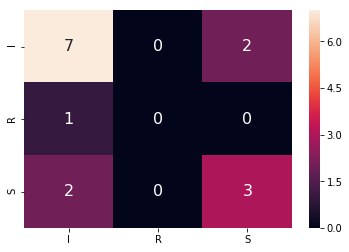

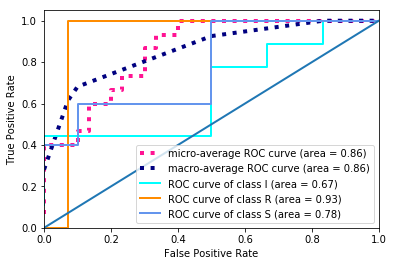


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.70      0.78      0.74         9
          R       0.00      0.00      0.00         1
          S       0.60      0.60      0.60         5

avg / total       0.62      0.67      0.64        15

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.95      1.00      0.98        20
          R       1.00      1.00      1.00         3
          S       1.00      0.91      0.95        11

avg / total       0.97      0.97      0.97        34



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


BaggingClassifier(base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [35]:
train_bagging_DT(X_reduced, y_reduced, True, cv=7, test_size=0.3)

0.39
# Tuning hyper-parameter

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



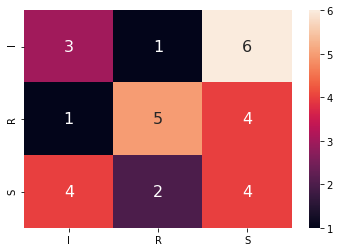

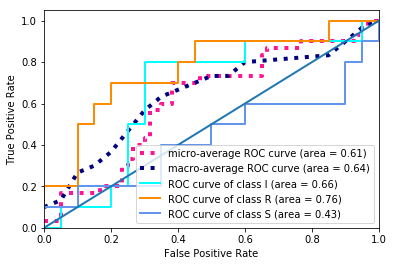


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.38      0.30      0.33        10
          R       0.62      0.50      0.56        10
          S       0.29      0.40      0.33        10

avg / total       0.43      0.40      0.41        30

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
          R       1.00      1.00      1.00        23
          S       1.00      1.00      1.00        22

avg / total       1.00      1.00      1.00        68



BaggingClassifier(base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [36]:
train_bagging_DT(X_reduced_aug, y_reduced_aug, True, cv=7, test_size=0.3) # BAD MODEL!

### SVM: Note that these all just give 100% improved

In [8]:
params = [{'C': [0.1,10,100, 1000], 'gamma': [0.1,1,10,100, 1000]}]
sv = GridSearchCV(svm.SVC(), cv=lpo, param_grid = params)
utils.do_CV(X,y, sv, multi_class=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.1, 'gamma': 0.1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 10}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 100}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 10, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 10}
0.555 (+/-0.557) for {'C': 10, 'gamma': 100}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 100, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 10}
0.555 (+/-0.557) for {'C': 100, 'gamma': 100}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 10}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 100}
0.555

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Tuning hyper-parameter

Best parameters set found on development set:

{'C': 10, 'gamma': 0.1}

Grid scores on development set:

0.500 (+/-0.560) for {'C': 0.1, 'gamma': 0.1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 10}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 100}
0.500 (+/-0.560) for {'C': 0.1, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 10, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1}
0.555 (+/-0.557) for {'C': 10, 'gamma': 10}
0.555 (+/-0.557) for {'C': 10, 'gamma': 100}
0.555 (+/-0.557) for {'C': 10, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 100, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1}
0.555 (+/-0.557) for {'C': 100, 'gamma': 10}
0.555 (+/-0.557) for {'C': 100, 'gamma': 100}
0.555 (+/-0.557) for {'C': 100, 'gamma': 1000}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 0.1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 1}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 10}
0.555 (+/-0.557) for {'C': 1000, 'gamma': 100}
0.555

/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/anna.merkoulovitch/miniconda3/envs/cs229-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


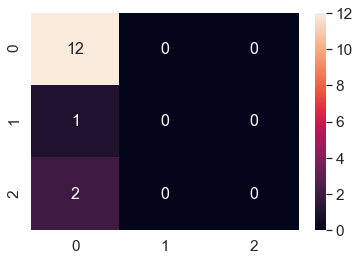

In [74]:
params = [{'C': [0.1,10,100, 1000], 'gamma': [0.1,1,10,100, 1000]}]
sv = GridSearchCV(svm.SVC(), cv=lpo, param_grid = params)
utils.do_CV(X,y, sv, multi_class=True)

### This can be ignored for now

In [7]:
def plot_learning_curve(model, X,y, cv):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y,
                                                            train_sizes=[5,10,15,20,25,30,35,40,45,48],
                                                            cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

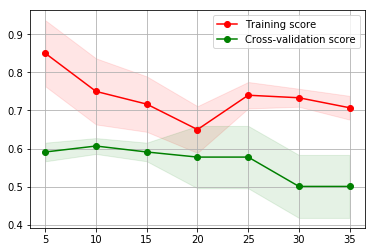

In [49]:
plot_learning_curve(knn, X,y, 4)

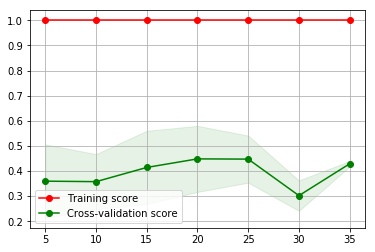

In [51]:
plot_learning_curve(logistic, X,y, 3)

In [ ]:
#pytorch
#pretrained embeddings
# extract a feature vector for any image with pytorch

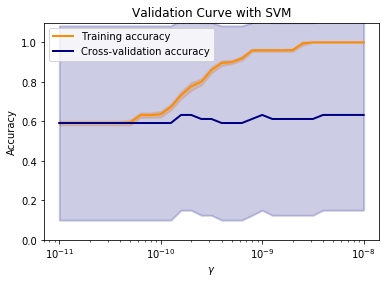

In [5]:
loo = model_selection.LeaveOneOut()
param_range = np.logspace(-11, -8, 31)

utils.generate_validation_curve(svm.SVC(), X, y, param_name="gamma", param_range=param_range,
                                cv=loo, scoring="accuracy", n_jobs=-1,
                                title="Validation Curve with SVM", xlabel="$\gamma$")

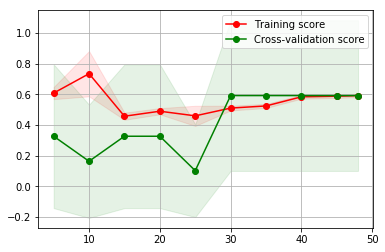

In [8]:
svm_classifier = svm.SVC(gamma=1e-11)
plot_learning_curve(svm_classifier, X,y, cv=loo)

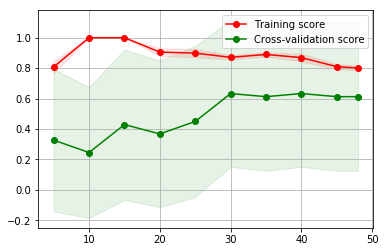

In [9]:
svm_classifier = svm.SVC(gamma=2.51188643e-10)
plot_learning_curve(svm_classifier, X,y, cv=loo)

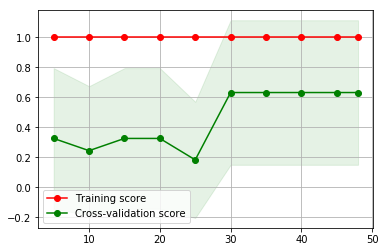

In [10]:
svm_classifier = svm.SVC(gamma=1e-8)
plot_learning_curve(svm_classifier, X,y, cv=loo)